# Imports

In [1]:
import numpy as np
import glob
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

# Load DataSet

0 means unlikely to have flood damage, 1 means likely to have flood damage

[0,1] --> damage

[1,0] --> no damage

## Load Training Set

In [2]:
images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/train_another/damage/*.jpeg')
dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  dmg_img.append(im_arr)
dmg_img = np.array(dmg_img)

images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/train_another/no_damage/*.jpeg')
no_dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  no_dmg_img.append(im_arr)
no_dmg_img = np.array(no_dmg_img)

X_train = np.concatenate((dmg_img, no_dmg_img))
dmg_img_y = np.array(dmg_img.shape[0] * [[0,1]])
no_dmg_img_y = np.array(no_dmg_img.shape[0] * [[1,0]])
y_train = np.concatenate((dmg_img_y, no_dmg_img_y))

# shuffle arrays so that the array is a mix of damage and no_damage in a random order
shuffler = np.random.permutation(X_train.shape[0])
X_train = X_train[shuffler]
y_train = y_train[shuffler]

## Load Validation Set

In [3]:
images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/validation_another/damage/*.jpeg')
dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  dmg_img.append(im_arr)
dmg_img = np.array(dmg_img)

images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/validation_another/no_damage/*.jpeg')
no_dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  no_dmg_img.append(im_arr)
no_dmg_img = np.array(no_dmg_img)

X_val = np.concatenate((dmg_img, no_dmg_img))
dmg_img_y = np.array(dmg_img.shape[0] * [[0,1]])
no_dmg_img_y = np.array(no_dmg_img.shape[0] * [[1,0]])
y_val = np.concatenate((dmg_img_y, no_dmg_img_y))

# shuffle arrays so that the array is a mix of damage and no_damage in a random order
shuffler = np.random.permutation(X_val.shape[0])
X_val = X_val[shuffler]
y_val = y_val[shuffler]

## Load Test Set

In [4]:
images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/test/damage/*.jpeg')
dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  dmg_img.append(im_arr)
dmg_img = np.array(dmg_img)

images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/test/no_damage/*.jpeg')
no_dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  no_dmg_img.append(im_arr)
no_dmg_img = np.array(no_dmg_img)

X_test = np.concatenate((dmg_img, no_dmg_img))
dmg_img_y = np.array(dmg_img.shape[0] * [[0,1]])
no_dmg_img_y = np.array(no_dmg_img.shape[0] * [[1,0]])
y_test = np.concatenate((dmg_img_y, no_dmg_img_y))

# shuffle arrays so that the array is a mix of damage and no_damage in a random order
shuffler = np.random.permutation(X_val.shape[0])
X_test = X_test[shuffler]
y_test = y_test[shuffler]

# Pre-Process DataSet

In [5]:
# pre-process data 
def scale_pixels(train, val, test):
	# convert from integers to floats and normalize between 0-1
  train_norm = train.astype('float32') / 255.0
  val_norm = val.astype('float32') / 255.0
  test_norm = test.astype('float32') / 255.0
	# return normalized images
  return train_norm, val_norm, test_norm

# Plot Diagnostics

In [6]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
  # blue = training data; orange = validation data
	# plot validation loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='validation')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='validation')

# Create CNN Model

In [7]:
# define cnn model
def define_model(learning_rate):
  model = keras.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(layers.Dense(2, activation='softmax'))  # compile model
  opt = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

## CNN Model with Batch Normalization

In [8]:
# define cnn model
def define_model_batch_normalization(learning_rate):
  model = keras.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(2, activation='softmax'))  # compile model
  opt = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

# Train Data
Hyperparameters are inputted into the function

In [10]:
def train(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # prepare pixel data
  X_train, X_val, X_test = scale_pixels(X_train, X_val, X_test)
  # define model
  model = define_model(learning_rate)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=5, verbose=1)
  # fit model
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

Epoch 1/75
157/157 [==============================] - 590s 4s/step - loss: 0.6518 - accuracy: 0.6027 - val_loss: 0.6575 - val_accuracy: 0.5645
Epoch 2/75
157/157 [==============================] - 587s 4s/step - loss: 0.5213 - accuracy: 0.7627 - val_loss: 0.3658 - val_accuracy: 0.8695
Epoch 3/75
157/157 [==============================] - 597s 4s/step - loss: 0.3981 - accuracy: 0.8464 - val_loss: 0.3612 - val_accuracy: 0.8605
Epoch 4/75
157/157 [==============================] - 599s 4s/step - loss: 0.3523 - accuracy: 0.8610 - val_loss: 0.3075 - val_accuracy: 0.8770
Epoch 5/75
157/157 [==============================] - 599s 4s/step - loss: 0.3030 - accuracy: 0.8788 - val_loss: 0.2844 - val_accuracy: 0.8795
Epoch 6/75
157/157 [==============================] - 593s 4s/step - loss: 0.2879 - accuracy: 0.8800 - val_loss: 0.2484 - val_accuracy: 0.8950
Epoch 7/75
157/157 [==============================] - 591s 4s/step - loss: 0.2562 - accuracy: 0.8961 - val_loss: 0.2356 - val_accuracy: 0.9010

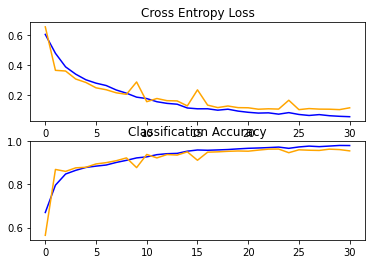

In [11]:
model, accuracy = train(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 75)
print(accuracy)

Epoch 1/75
157/157 [==============================] - 627s 4s/step - loss: 0.6638 - accuracy: 0.5957 - val_loss: 0.4783 - val_accuracy: 0.8300
Epoch 2/75
157/157 [==============================] - 583s 4s/step - loss: 0.5290 - accuracy: 0.7500 - val_loss: 0.7084 - val_accuracy: 0.6365
Epoch 3/75
157/157 [==============================] - 582s 4s/step - loss: 0.5182 - accuracy: 0.7621 - val_loss: 0.3333 - val_accuracy: 0.8765
Epoch 4/75
157/157 [==============================] - 582s 4s/step - loss: 0.3622 - accuracy: 0.8588 - val_loss: 0.3288 - val_accuracy: 0.8735
Epoch 5/75
157/157 [==============================] - 590s 4s/step - loss: 0.3273 - accuracy: 0.8699 - val_loss: 0.2654 - val_accuracy: 0.8890
Epoch 6/75
157/157 [==============================] - 593s 4s/step - loss: 0.2585 - accuracy: 0.8946 - val_loss: 0.2804 - val_accuracy: 0.8860
Epoch 7/75
157/157 [==============================] - 593s 4s/step - loss: 0.2476 - accuracy: 0.9005 - val_loss: 0.2633 - val_accuracy: 0.9070

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()


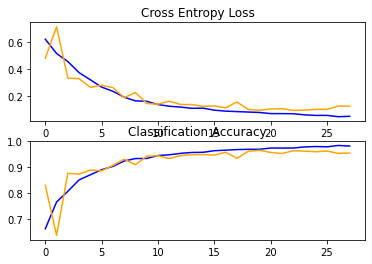

In [11]:
model_test, accuracy = train(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 75)
print(accuracy)
y_pred = model_test.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

## Train Data with Batch Normalization

In [10]:
def train_batch_normalization(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # prepare pixel data
  X_train, X_val, X_test = scale_pixels(X_train, X_val, X_test)
  # define model
  model = define_model_batch_normalization(learning_rate)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=5, verbose=1)
  # fit model
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

Epoch 1/75
157/157 [==============================] - 750s 5s/step - loss: 0.3876 - accuracy: 0.8488 - val_loss: 3.0177 - val_accuracy: 0.5000
Epoch 2/75
157/157 [==============================] - 745s 5s/step - loss: 0.1036 - accuracy: 0.9627 - val_loss: 2.3999 - val_accuracy: 0.5030
Epoch 3/75
157/157 [==============================] - 738s 5s/step - loss: 0.0640 - accuracy: 0.9802 - val_loss: 1.0585 - val_accuracy: 0.6375
Epoch 4/75
157/157 [==============================] - 741s 5s/step - loss: 0.0523 - accuracy: 0.9868 - val_loss: 0.1130 - val_accuracy: 0.9600
Epoch 5/75
157/157 [==============================] - 754s 5s/step - loss: 0.0344 - accuracy: 0.9917 - val_loss: 0.1168 - val_accuracy: 0.9625
Epoch 6/75
157/157 [==============================] - 749s 5s/step - loss: 0.0268 - accuracy: 0.9952 - val_loss: 0.1042 - val_accuracy: 0.9600
Epoch 7/75
157/157 [==============================] - 752s 5s/step - loss: 0.0190 - accuracy: 0.9983 - val_loss: 0.1161 - val_accuracy: 0.9625

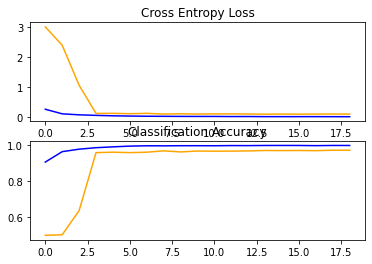

In [13]:
model, accuracy = train_batch_normalization(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 75)
print(accuracy)

Epoch 1/75
157/157 [==============================] - 769s 5s/step - loss: 0.3877 - accuracy: 0.8468 - val_loss: 2.2499 - val_accuracy: 0.5000
Epoch 2/75
157/157 [==============================] - 764s 5s/step - loss: 0.1117 - accuracy: 0.9625 - val_loss: 0.6447 - val_accuracy: 0.6665
Epoch 3/75
157/157 [==============================] - 768s 5s/step - loss: 0.0841 - accuracy: 0.9722 - val_loss: 0.1678 - val_accuracy: 0.9400
Epoch 4/75
157/157 [==============================] - 767s 5s/step - loss: 0.0603 - accuracy: 0.9818 - val_loss: 0.1279 - val_accuracy: 0.9535
Epoch 5/75
157/157 [==============================] - 764s 5s/step - loss: 0.0454 - accuracy: 0.9893 - val_loss: 0.1060 - val_accuracy: 0.9575
Epoch 6/75
157/157 [==============================] - 767s 5s/step - loss: 0.0365 - accuracy: 0.9936 - val_loss: 0.1078 - val_accuracy: 0.9555
Epoch 7/75
157/157 [==============================] - 768s 5s/step - loss: 0.0233 - accuracy: 0.9970 - val_loss: 0.1878 - val_accuracy: 0.9325

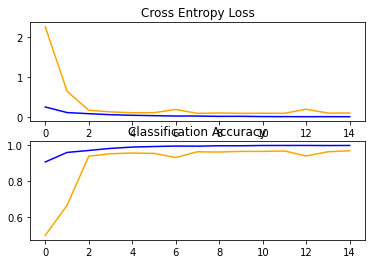

In [11]:
model_test_batch_normalization, accuracy = train_batch_normalization(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 75)
print(accuracy)
y_pred = model_test_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

## Train Data with Data Augmentation

In [9]:
def train_data_augmentation(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # prepare pixel data
  X_train, X_val, X_test = scale_pixels(X_train, X_val, X_test)
  # define model
  model = define_model(learning_rate)
  # create data generator
  datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
  # prepare iterator
  it_train = datagen.flow(X_train, y_train, batch_size=64)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=5, verbose=1)
	# fit model
  steps = int(X_train.shape[0] / 64)
  history = model.fit(it_train, epochs=epochs, steps_per_epoch=steps, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

Epoch 1/100
156/156 [==============================] - 708s 5s/step - loss: 0.6795 - accuracy: 0.5788 - val_loss: 0.5717 - val_accuracy: 0.7170
Epoch 2/100
156/156 [==============================] - 701s 4s/step - loss: 0.5496 - accuracy: 0.7292 - val_loss: 0.4563 - val_accuracy: 0.8045
Epoch 3/100
156/156 [==============================] - 691s 4s/step - loss: 0.4444 - accuracy: 0.8178 - val_loss: 0.3401 - val_accuracy: 0.8755
Epoch 4/100
156/156 [==============================] - 696s 4s/step - loss: 0.3894 - accuracy: 0.8490 - val_loss: 0.3747 - val_accuracy: 0.8500
Epoch 5/100
156/156 [==============================] - 693s 4s/step - loss: 0.3459 - accuracy: 0.8577 - val_loss: 0.2813 - val_accuracy: 0.8855
Epoch 6/100
156/156 [==============================] - 723s 5s/step - loss: 0.2893 - accuracy: 0.8866 - val_loss: 0.3186 - val_accuracy: 0.8740
Epoch 7/100
156/156 [==============================] - 700s 4s/step - loss: 0.2596 - accuracy: 0.8943 - val_loss: 0.2316 - val_accuracy:

0.9490000009536743

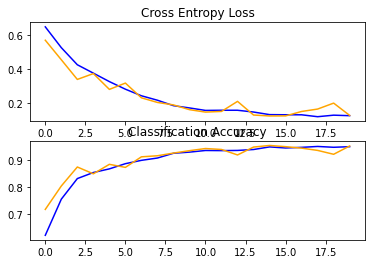

In [10]:
model, accuracy = train_data_augmentation(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 100)
print(accuracy)

## Train Data with Data Augmentation and Batch Normalization

In [9]:
def train_data_augmentation_batch_normalization(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # prepare pixel data
  X_train, X_val, X_test = scale_pixels(X_train, X_val, X_test)
  # define model
  model = define_model_batch_normalization(learning_rate)
  # create data generator
  datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
  # prepare iterator
  it_train = datagen.flow(X_train, y_train, batch_size=64)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=5, verbose=1)
	# fit model  
  steps = int(X_train.shape[0] / 64)
  history = model.fit(it_train, epochs=epochs, steps_per_epoch=steps, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

Epoch 1/100
156/156 [==============================] - 687s 4s/step - loss: 0.4066 - accuracy: 0.8375 - val_loss: 3.1104 - val_accuracy: 0.5000
Epoch 2/100
156/156 [==============================] - 684s 4s/step - loss: 0.1638 - accuracy: 0.9400 - val_loss: 1.6111 - val_accuracy: 0.5205
Epoch 3/100
156/156 [==============================] - 686s 4s/step - loss: 0.1384 - accuracy: 0.9443 - val_loss: 0.4796 - val_accuracy: 0.7825
Epoch 4/100
156/156 [==============================] - 686s 4s/step - loss: 0.1197 - accuracy: 0.9515 - val_loss: 0.1076 - val_accuracy: 0.9595
Epoch 5/100
156/156 [==============================] - 686s 4s/step - loss: 0.1062 - accuracy: 0.9599 - val_loss: 0.1340 - val_accuracy: 0.9475
Epoch 6/100
156/156 [==============================] - 685s 4s/step - loss: 0.1010 - accuracy: 0.9655 - val_loss: 0.2269 - val_accuracy: 0.9145
Epoch 7/100
156/156 [==============================] - 685s 4s/step - loss: 0.0972 - accuracy: 0.9629 - val_loss: 0.2905 - val_accuracy:

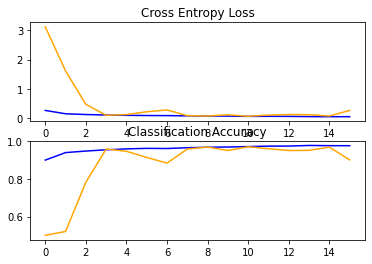

In [22]:
model, accuracy = train_data_augmentation_batch_normalization(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 100)
print(accuracy)

Epoch 1/100
156/156 [==============================] - 683s 4s/step - loss: 0.4070 - accuracy: 0.8458 - val_loss: 2.5823 - val_accuracy: 0.5000
Epoch 2/100
156/156 [==============================] - 691s 4s/step - loss: 0.1596 - accuracy: 0.9406 - val_loss: 1.2286 - val_accuracy: 0.5545
Epoch 3/100
156/156 [==============================] - 689s 4s/step - loss: 0.1179 - accuracy: 0.9554 - val_loss: 0.2591 - val_accuracy: 0.8945
Epoch 4/100
156/156 [==============================] - 687s 4s/step - loss: 0.1172 - accuracy: 0.9565 - val_loss: 0.1046 - val_accuracy: 0.9655
Epoch 5/100
156/156 [==============================] - 684s 4s/step - loss: 0.0997 - accuracy: 0.9621 - val_loss: 0.1329 - val_accuracy: 0.9540
Epoch 6/100
156/156 [==============================] - 687s 4s/step - loss: 0.0931 - accuracy: 0.9677 - val_loss: 0.1149 - val_accuracy: 0.9590
Epoch 7/100
156/156 [==============================] - 689s 4s/step - loss: 0.0826 - accuracy: 0.9684 - val_loss: 0.1518 - val_accuracy:

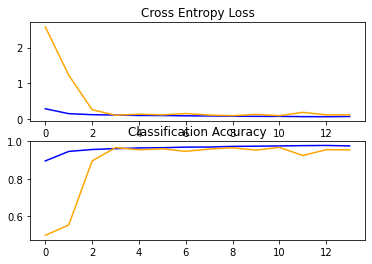

In [10]:
model_tet_data_augmentation_batch_normalization, accuracy = train_data_augmentation_batch_normalization(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 100)
print(accuracy)
y_pred = model_tet_data_augmentation_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

## Train Data with Data Augmentation and Dropout Regularization and Batch Normalization

In [ ]:
def train_data_augmentation_dropout_batch(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # prepare pixel data
  X_train, X_val, X_test = scale_pixels(X_train, X_val, X_test)
  # define model
  model = define_model_dropout_regularization_batch_normalization(learning_rate)
  # create data generator
  datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
  # prepare iterator
  it_train = datagen.flow(X_train, y_train, batch_size=64)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=10, verbose=1)
	# fit model
  steps = int(X_train.shape[0] / 64)
  history = model.fit(it_train, epochs=epochs, steps_per_epoch=steps, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

In [ ]:
model, accuracy = train_data_augmentation_dropout_batch(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 150) # patience for early stopping = 10
print(accuracy)